In [84]:
import pandas as pd
import requests

eia_api_key = "RMBRFywOdWtQoqGw4n0YgNIC70kPNwd4GhkNiMnt"

In [98]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
if openai_api_key and anthropic_api_key:
   print("API key loaded successfully!")
else:
   print("Failed to load API key. Check your .env file.")

API key loaded successfully!


In [85]:
import requests
import pandas as pd

def get_eia_electricity_data(api_key, **kwargs):
    base_url = "https://api.eia.gov/v2/electricity/retail-sales/data/"
    params = {
        "api_key": api_key,
        **kwargs,
    }
    
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    
    data = response.json()
    
    return data

def get_eia_natural_gas_data(api_key, **kwargs):
    base_url = "https://api.eia.gov/v2/natural-gas/pri/sum/data/"
    params = {
        "api_key": api_key,
        **kwargs,
    }
    
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    
    data = response.json()
    
    return data

## Electricity Prices

In [86]:
# Example usage
params = {
    'frequency' : 'monthly',
    'data[0]' : 'customers',
    'data[1]' : 'price',
    'data[2]' : 'revenue',
    'data[3]' : 'sales',
    'start' : '2018-01',
    'end' : '2024-05',
    'sort[0][column]' : 'period',
    'sort[0][direction]' : 'desc',
    'length' : '5000',
}


offset = 0
results = []
more = True
print(f"Obtaining data from EIA")
while more:
    print(f"offset: {offset}")
    r = get_eia_electricity_data(
        api_key=eia_api_key,
        **params,
        offset=offset
    )
    data = r['response']['data']
    if len(data)==0:
        #got all the data
        more=False
    offset += len(data)
    results += data
df = pd.DataFrame(data=results)
df.to_csv('eia_electricity_by_sector.csv', index=False)

Obtaining data from EIA
offset: 0
offset: 5000
offset: 10000
offset: 15000
offset: 20000
offset: 25000
offset: 28644


<Axes: xlabel='state', ylabel='$/kWh'>

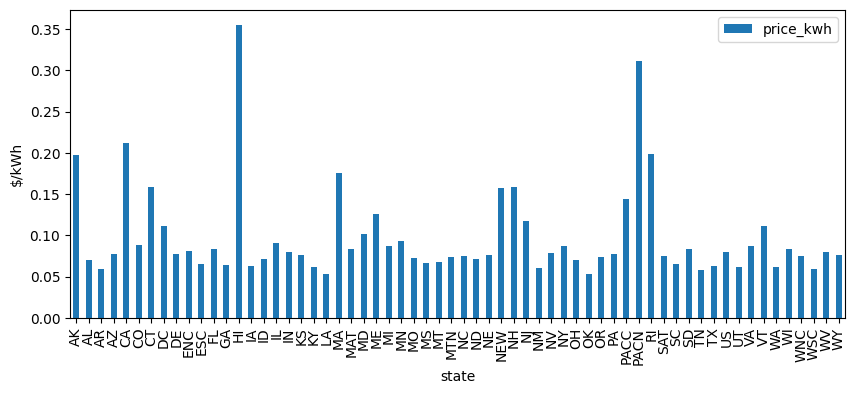

In [87]:
sector_names = ['industrial']

# units = ['$/MCF']
filter_df = df.copy()
filter_df = filter_df[filter_df['sectorName'].isin(sector_names)]
filter_df = filter_df[filter_df['period'].isin(['2024-05'])]
filter_df['state'] = filter_df['stateid']
filter_df['price'] = pd.to_numeric(df['price'], errors='coerce').dropna()
filter_df['price_kwh'] = filter_df['price']/100
filter_df = filter_df.dropna(subset=['state'])
filter_df = filter_df.sort_values(by=['period','state']).reset_index(drop=True)
filter_df.to_csv('eia_electricity_price.csv', index=False)
filter_df.plot.bar(x='state', y='price_kwh',ylabel='$/kWh',figsize=(10,4))

In [88]:
eia_df = filter_df.copy()

## Natural Gas Prices

In [89]:
# Example usage
params = {
    'frequency' : 'monthly',
    'data[0]' : 'value',
    'start' : '2018-01',
    'end' : '2024-05',
    'sort[0][column]' : 'period',
    'sort[0][direction]' : 'desc',
    'length' : '5000',
}


offset = 0
results = []
more = True
print(f"Obtaining data from EIA")
while more:
    print(f"offset: {offset}")
    r = get_eia_natural_gas_data(
        api_key=eia_api_key,
        **params,
        offset=offset,
    )
    data = r['response']['data']
    if len(data)==0:
        #got all the data
        more=False
    offset += len(data)
    results += data
df = pd.DataFrame(data=results)

Obtaining data from EIA
offset: 0
offset: 5000
offset: 10000
offset: 15000
offset: 20000
offset: 25000
offset: 30000
offset: 32072


<Axes: xlabel='state', ylabel='$/MMBtu'>

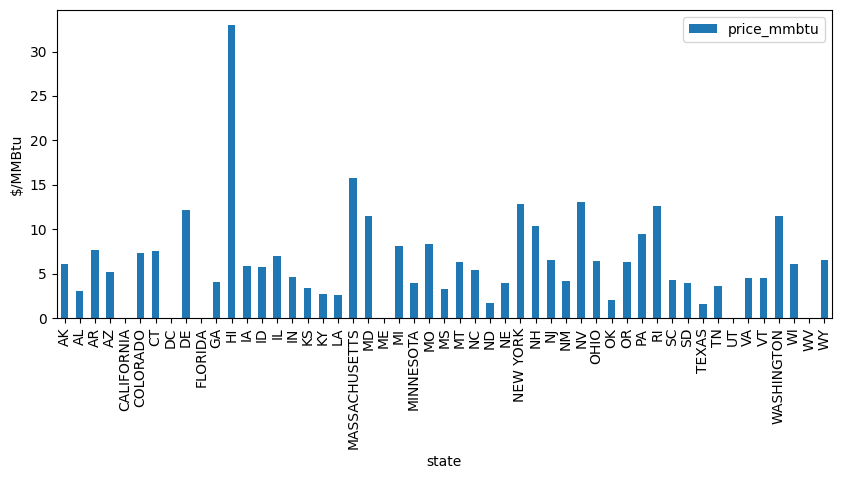

In [90]:
process_names = ['Industrial Price','Imports Price', 'Exports (Price)',]
units = ['$/MCF']
filter_df = df.copy()
filter_df = filter_df[filter_df['units'].isin(units) & filter_df['process-name'].isin(process_names)]
filter_df = filter_df[filter_df['period'].isin(['2024-04'])]
#convert to price
filter_df['value'] = pd.to_numeric(df['value'], errors='coerce').dropna()
mmbtu_per_mcf = 1.037
filter_df['price_mmbtu'] = filter_df['value']*mmbtu_per_mcf
def split_area_name(area_name):
    first, _, second = area_name.partition('-')
    if first.lower() == 'usa':
        return second
    elif first == 'U.S.':
        return None
    return first
filter_df['state'] = filter_df['area-name'].apply(split_area_name)
filter_df = filter_df.dropna(subset=['state'])
filter_df = filter_df.sort_values(by=['period','state']).reset_index(drop=True)
filter_df.to_csv('eia_natural_gas_price.csv', index=False)
filter_df.plot.bar(x='state', y='price_mmbtu',ylabel='$/MMBtu',figsize=(10,4))

In [91]:
ng_df = filter_df.copy()

## Plot

In [125]:
import pathlib
import pandas

knowledge_dir = pathlib.Path("../+knowledge/world_maps")
knowledge_filenames = [
    str(p)
    for p in knowledge_dir.iterdir()
    if p.suffix in ['.csv']
]
display(knowledge_filenames)
datasets = {
    p : pd.read_csv(p, sep=',', index_col=False)
    for p in knowledge_filenames
}

['../+knowledge/world_maps/eu_electricity_EUR2021MWh.csv',
 '../+knowledge/world_maps/eia_electricity_price.csv',
 '../+knowledge/world_maps/eu_natural_gas_EUR2021MWh.csv',
 '../+knowledge/world_maps/eia_natural_gas_price.csv']

In [141]:
import json
import anthropic
client = anthropic.Anthropic()

countries = datasets['../+knowledge/world_maps/eu_electricity_EUR2021MWh.csv'].columns.to_list()[4:]
states = ng_df['state'].unique().tolist() 
locations =states

system="""You only know how to return valid json strings. 

You do not respond with any other comments, text, or language unless it is json.

If you must communicate a message you do so by adding a message field to a json"""

message = f"""I am going to pass you a list of locations. 

I want you to:
- identify the latitude and longitude of each location
- return to me a json that has a list of objects with the following fields:
    - id: the original string you used to determine what the location name is
    - name : the name of the location
    - latitude: that latiutude of the location
    - longtitude : the longitude of the location

The list of locations is:
{locations}
"""
response = client.messages.create(
        model="claude-3-haiku-20240307",
        system=system,
        max_tokens=4096,
                messages=[
            {"role": "user", "content": message},
        ],
        temperature=0.0,
    )
data = json.loads(response.content[-1].text)
state_locations = data['locations']

In [142]:
import json
import anthropic
client = anthropic.Anthropic()

countries = datasets['../+knowledge/world_maps/eu_electricity_EUR2021MWh.csv'].columns.to_list()[4:]
states = ng_df['state'].unique().tolist() 
locations =countries

system="""You only know how to return valid json strings. 

You do not respond with any other comments, text, or language unless it is json.

If you must communicate a message you do so by adding a message field to a json"""

message = f"""I am going to pass you a list of locations. 

I want you to:
- identify the latitude and longitude of each location
- return to me a json that has a list of objects with the following fields:
    - id: the original string you used to determine what the location name is
    - name : the name of the location
    - latitude: that latiutude of the location
    - longtitude : the longitude of the location

The list of locations is:
{locations}
"""
response = client.messages.create(
        model="claude-3-haiku-20240307",
        system=system,
        max_tokens=4096,
                messages=[
            {"role": "user", "content": message},
        ],
        temperature=0.0,
    )
data = json.loads(response.content[-1].text)
country_locations = data['locations']

## World Map

In [143]:
locations = country_locations + state_locations

latitudes = [location['latitude'] for location in locations]
longitudes = [location['longitude'] for location in locations]
labels = [location['name'] for location in locations]

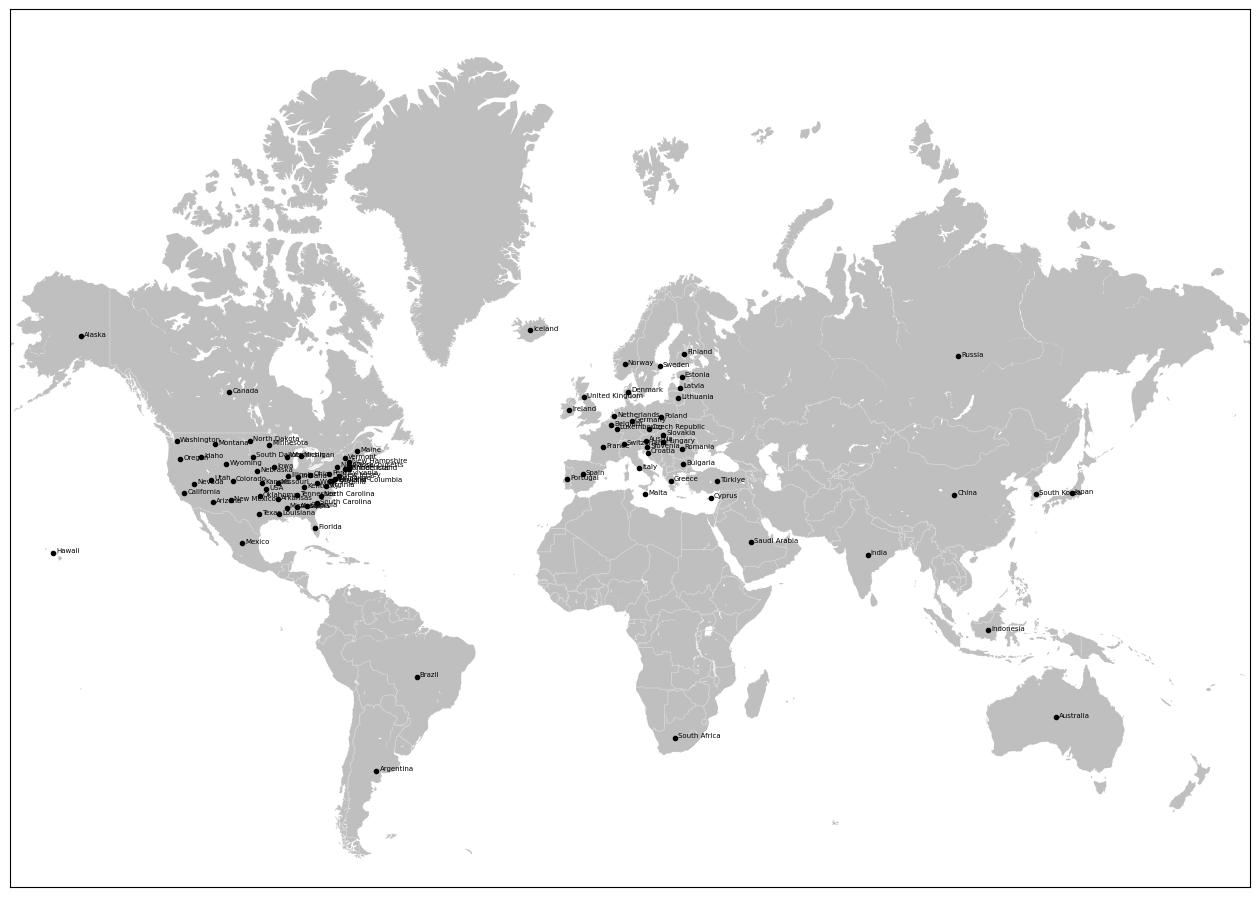

In [147]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
 
# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
fig, ax = plt.subplots(1,1, figsize=(16,12))

my_map = Basemap(
    projection='merc', 
    lon_0=0, lat_0=0, 
    resolution = 'l', area_thresh = 1000.0,
    llcrnrlon=-170, llcrnrlat=-60,
    urcrnrlon=190, urcrnrlat=85,
    ax=ax
)
# my_map.drawcoastlines(linewidth=0.5,color='grey')
my_map.drawcountries(color='#dbdbdb')
my_map.fillcontinents(color='#bfbfbf')
# my_map.drawmapboundary(linewidth=0)


x,y = my_map(longitudes, latitudes)
my_map.plot(
    x, y, 
    linewidth=0,
    marker='.', markersize=6,
    color='black'
)

for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt+100000, ypt+5000, label, fontdict={'fontsize' : 5})
plt.close()
display(fig)